# Terminal velocity of air bubbles rising in water

Experimental rise velocities have been extracted from [Tomiyama et al. (1998)](https://www.jstage.jst.go.jp/article/jsmeb1993/41/2/41_2_472/_article) using [Engauge Digitizer](http://markummitchell.github.io/engauge-digitizer/). The bubble diameter $d_b$ in the extracted data has the unit $mm$. The bubble velocity is given in $cm/s$ (*water* file; extracted from Tomiyama et al. 1998; originally published in the Clift-Grace-Weber book on page 172). The reference curve for the contaminated bubble was also extracted from Clift et al. 1978 using Digitizer (figure 7.3 on page 172).

## Dependencies

This notebook has no dependencies to other notebooks.

Data

- ../data/tomiyama1998/tomiyama1998.csv
- ../data/tomiyama1998/curve_cont.csv

## Data and visualization

In [1]:
import pandas as pd
import numpy as np
import helper_module as hm
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker

data_path = "../data/tomiyama1998/"
file_water = "tomiyama1998.csv"
file_water_cont = "curve_cont.csv"

U_water = pd.read_csv(data_path + file_water, header=0, names=["d_b", "U_b"])
U_water_cont = pd.read_csv(data_path + file_water_cont, header=0, names=["d_b", "U_b"])

print(U_water.head(2))
print("\nThere are {:3d} data points for the air-water system.".format(U_water.shape[0]))

        d_b      U_b
0  0.230098  2.19333
1  0.274692  2.76514

There are 129 data points for the air-water system.


## Definition of some helper functions

In [2]:
def drag_tomiyama_pure(Re, Eo):
    '''Compute drag coefficient based on Reynolds and Etvos number for bubbles rising in pure systems.
       This functions implements equation 31 of Tomiyama et al. 1998.
       
    Parameters
    ----------
    Re - array-like: Reynolds number
    Eo - array-like: Etvos number
    
    Return
    ------
    c_d - array-like: The drag-coefficient for a pure system.
    
    '''
    drag_large = 8.0 / 3.0 * Eo / (Eo + 4.0)
    drag_levich = 48.0 / Re
    drag_levich_mod = 16.0 / Re * (1.0 + 0.15 * np.power(Re, 0.687))
    return np.maximum(np.minimum(drag_levich_mod, drag_levich), drag_large)


def drag_tomiyama_contaminated(Re, Eo):
    '''Compute drag coefficient based on Reynolds and Etvos number for bubbles rising in contaminated systems.
       This functions implements equation 33 of Tomiyama et al. 1998.
       
    Parameters
    ----------
    Re - array-like: Reynolds number
    Eo - array-like: Etvos number
    
    Return
    ------
    c_d - array-like: The drag-coefficient for a contaminated system.
    
    '''
    drag_large = 8.0 / 3.0 * Eo / (Eo + 4.0)
    drag_rigid = 24.0 / Re * (1.0 + 0.15 * np.power(Re, 0.687))
    return np.maximum(drag_rigid, drag_large)


def zero_condition(drag, d_b, u_b, rho_l, rho_g):
    '''Compute the difference between drag and buoyancy force.
       This function implements equation 5 in Tomiyama et al. 1998 and expects SI units.
    
    Parameters
    ----------
    drag - float  : value of the drag coefficient
    d_b - float   : equivalent bubble diameter
    u_b - float   : bubble rise velocity
    rho_l - float : liquid density
    rho_g - float : gas density
    
    Returns
    -------
    diff - float : difference between drag and buoyancy forces
    '''
    return 4.0*(rho_l-rho_g)*9.81*d_b / (3.0*drag*rho_l) - np.power(u_b, 2)


def compute_rise_velocity(drag, d_b, rho_l, rho_g, nu_l, sigma):
    '''Compute the terminal velocity iteratively for a given drag correlation.
       The Function expects parameters in SI units.
       
    Parameters
    ----------
    drag - function: function to compute the drag
    d_b - float    : equivalent bubble diameter
    rho_l - float  : density of liquid phase
    rho_g - float  : density of gas phase
    nu_l - float   : kinematic liquid viscosity
    sigma - float  : surface tension coefficient
    
    Returns
    -------
    u_b - float    : bubble rise velocity
    
    '''
    u_min = 0.01
    u_max = 0.5
    re_min = u_min * d_b / nu_l
    eo_min = 9.81 * rho_l * d_b**2 / sigma
    current_drag = drag(re_min, eo_min)
    res_min = zero_condition(current_drag, d_b, u_min, rho_l, rho_g)
    u_b = 0.1
    converged = False
    count = 0
    while (count < 100) and not converged:
        re = u_b * d_b / nu_l
        eo = 9.81 * rho_l * d_b**2 / sigma
        current_drag = drag(re, eo)
        res = zero_condition(current_drag, d_b, u_b, rho_l, rho_g) / u_b
        if np.absolute(res) < 1.0E-12:
            converged = True
        else:
            if (res_min * res) > 0.0:
                u_min = u_b
            else:
                u_max = u_b
            u_b = 0.5 * (u_min + u_max)
            count += 1
    return u_b

## Air bubbles rising in water at $20^\circ C$

In [3]:
rho_l = 998.21
rho_g = 1.2041
mu_l = 1.002E-3
sigma = 72.75E-3

# reference curves
d_ref = np.append(np.linspace(0.2, 1.3, 50), np.linspace(1.3, 40, 50))/ 1000
u_pure_ref = np.asarray([compute_rise_velocity(drag_tomiyama_pure, d, rho_l, rho_g, mu_l/rho_l, sigma) for d in d_ref])
u_cont_ref = np.asarray([compute_rise_velocity(drag_tomiyama_contaminated, d, rho_l, rho_g, mu_l/rho_l, sigma) for d in d_ref])

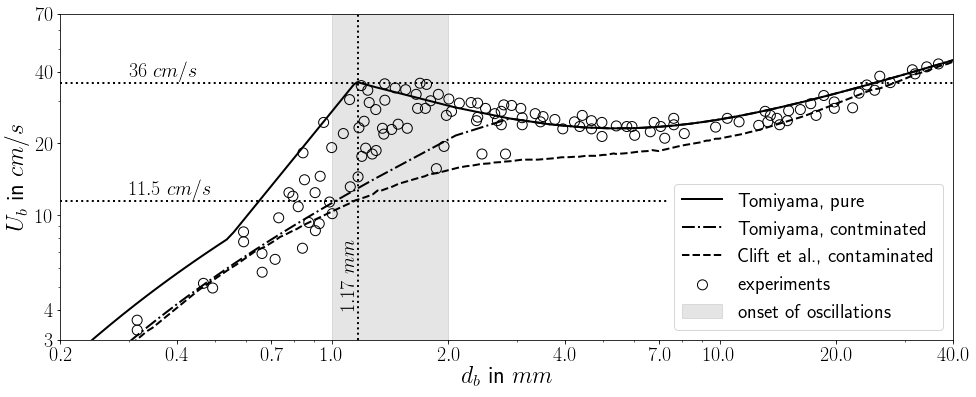

In [4]:
rc('text', usetex=True)
%matplotlib inline

fig, ax = plt.subplots(figsize=(hm.figure_width, 6))

plt.plot(d_ref*1000, u_pure_ref*100, color='k', linewidth=2, label="Tomiyama, pure")
plt.plot(d_ref*1000, u_cont_ref*100, color='k', ls="-.", linewidth=2, label="Tomiyama, contminated")
plt.plot(U_water_cont.d_b.values, U_water_cont.U_b.values, ls='--', color='k', linewidth=2, label="Clift et al., contaminated")
ax.scatter(U_water.d_b.values, U_water.U_b.values, marker='o', s=100, color='k', facecolors='none', label="experiments")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.2, 0.4, 0.7, 1, 2, 4, 7, 10, 20, 40])
ax.set_yticks([3, 4, 10, 20, 40, 70])
ax.tick_params(axis='both', which='major', labelsize=hm.fontsize_tick)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.2, 40])
ax.set_ylim([3, 70])
ax.set_xlabel(r"$d_b$ in $mm$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$U_b$ in $cm/s$", fontsize=hm.fontsize_label)
ax.fill_between([1.0, 2.0], [70, 70], color="k", alpha=0.1, label="onset of oscillations")
ax.legend(fontsize=hm.fontsize_legend)
ax.axvline(1.17, ls=":", lw=2, color="k")
ax.axhline(36, ls=":", lw=2, color="k")
ax.axhline(11.5, 0.0, 0.68, ls=":", lw=2, color="k")
ax.text(0.3, 38, r"$36~cm/s$", fontsize=hm.fontsize_legend)
ax.text(0.3, 12.2, r"$11.5~cm/s$", fontsize=hm.fontsize_legend)
ax.text(1.05, 7, r"$1.17~mm$", rotation=90, fontsize=hm.fontsize_legend)

plt.savefig('../output/ub_vs_db_water.pdf', bbox_inches='tight')
plt.savefig('../output/ub_vs_db_water.png', bbox_inches='tight')

## Estimate boundary layer thickness and resolution requirements

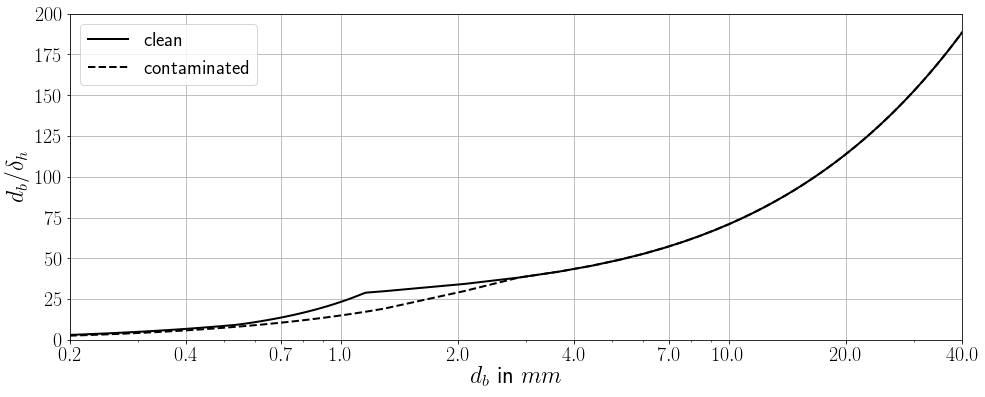

In [5]:
re_pure = u_pure_ref * d_ref * rho_l / mu_l
re_cont = u_cont_ref * d_ref * rho_l / mu_l
delta_pure = d_ref / np.sqrt(2.0 * re_pure)
delta_cont = d_ref / np.sqrt(2.0 * re_cont)
res_pure = d_ref / delta_pure
res_cont = d_ref / delta_cont

fig, ax = plt.subplots(figsize=(hm.figure_width, 6))
ax.plot(d_ref*1000, res_pure, lw=2, color="k", ls="-", label=r"clean")
ax.plot(d_ref*1000, res_cont, lw=2, color="k", ls="--", label=r"contaminated")
ax.tick_params(axis='both', which='major', labelsize=hm.fontsize_tick)
ax.set_xlabel(r"$d_b$ in $mm$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$d_b/\delta_h$", fontsize=hm.fontsize_label)
ax.grid(True)
ax.set_xlim(0.2, 40)
ax.set_ylim(0.0, 200)
ax.set_xscale('log')
ax.set_xticks([0.2, 0.4, 0.7, 1, 2, 4, 7, 10, 20, 40])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.legend(fontsize=hm.fontsize_legend)

In [6]:
d_table = np.linspace(0.001, 0.007, 7)
u_pure_table = np.asarray([compute_rise_velocity(drag_tomiyama_pure, d, rho_l, rho_g, mu_l/rho_l, sigma) for d in d_table])
u_cont_table = np.asarray([compute_rise_velocity(drag_tomiyama_contaminated, d, rho_l, rho_g, mu_l/rho_l, sigma) for d in d_table])
re_pure = u_pure_table * d_table * rho_l / mu_l
re_cont = u_cont_table * d_table * rho_l / mu_l
delta_pure = d_table / np.sqrt(2.0 * re_pure)
delta_cont = d_table / np.sqrt(2.0 * re_cont)
res_pure = d_table / delta_pure
res_cont = d_table / delta_cont
columns = ["d_b", "Re_clean", "delta_clean", "N_clean", "Re_cont", "delta_cont", "N_cont"]
table = pd.DataFrame(np.asarray([d_table, re_pure, delta_pure, res_pure, re_cont, delta_cont, res_cont]).T, columns=columns)
table

,d_b,Re_clean,delta_clean,N_clean,Re_cont,delta_cont,N_cont
0,0.001,270.116248,0.000043,23.242902,111.809228,0.000067,14.953878
1,0.002,572.597951,0.000059,33.840743,414.515049,0.000069,28.792883
2,0.003,751.487863,0.000077,38.768231,751.487863,0.000077,38.768231
3,0.004,942.930149,0.000092,43.426493,942.930149,0.000092,43.426493
4,0.005,1153.338954,0.000104,48.027887,1153.338954,0.000104,48.027887
5,0.006,1384.603551,0.000114,52.623256,1384.603551,0.000114,52.623256
6,0.007,1636.795214,0.000122,57.215299,1636.795214,0.000122,57.215299
